In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

df = pd.read_csv('./train.csv')
df.head()

,id,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,label
0,0,1.237666e+18,223.818272,19.918549,20.01995,18.61652,17.81234,17.36830,17.05670,4678,3,148,3.142504e+18,0.178004,2791,54556,427,0
1,1,1.237668e+18,207.866352,21.651873,17.87874,16.72789,16.71315,16.75816,16.82370,5183,5,490,3.117752e+18,-0.000041,2769,54527,491,2
2,2,1.237679e+18,328.585779,2.229687,27.14565,22.64610,20.92246,19.83694,19.23603,7712,4,120,5.795190e+18,0.558458,5147,55854,667,0
3,3,1.237681e+18,330.900844,30.407209,23.89204,22.71284,21.21638,20.03538,19.33082,8156,4,69,6.711640e+18,-0.000103,5961,56460,549,2
4,4,1.237662e+18,250.743112,23.739861,18.41437,16.64718,15.73495,15.23219,14.81856,3926,3,178,1.592087e+18,0.030478,1414,53135,233,0


In [2]:
df = df.set_index('id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 59999
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       60000 non-null  float64
 1   alpha        60000 non-null  float64
 2   delta        60000 non-null  float64
 3   u            60000 non-null  float64
 4   g            60000 non-null  float64
 5   r            60000 non-null  float64
 6   i            60000 non-null  float64
 7   z            60000 non-null  float64
 8   run_ID       60000 non-null  int64  
 9   cam_col      60000 non-null  int64  
 10  field_ID     60000 non-null  int64  
 11  spec_obj_ID  60000 non-null  float64
 12  redshift     60000 non-null  float64
 13  plate        60000 non-null  int64  
 14  MJD          60000 non-null  int64  
 15  fiber_ID     60000 non-null  int64  
 16  label        60000 non-null  int64  
dtypes: float64(10), int64(7)
memory usage: 8.2 MB


In [3]:
df.label.value_counts()

0    35746
2    12960
1    11294
Name: label, dtype: int64

In [4]:
# data
X = df.iloc[:,:-1]
Y = df.iloc[:, -1]

In [14]:
# train data
lens = len(X)
X_train, Y_train = X[:int(lens*0.8)], Y[:int(lens*0.8)]

# normalization
X_train = (X_train-X.min(axis=0))/(X_train.max(axis=0)-X.min(axis=0))
# test data
X_test, Y_test = X[int(lens*0.8):], Y[int(lens*0.8):]

# normalization
X_test = (X_test-X.min(axis=0))/(X_test.max(axis=0)-X.min(axis=0))

In [15]:
# Create the model using the Sequential API
model = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax) # ouput layer, softmax activation
])

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=['accuracy'])

# Create a learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

# Fit the model
history = model.fit(X_train, Y_train, epochs=100, verbose=1, callbacks=[lr_scheduler])

# Evaluate our model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

Epoch 1/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.9645 - accuracy: 0.5955
Epoch 2/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.9403 - accuracy: 0.5960
Epoch 3/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.9088 - accuracy: 0.5987
Epoch 4/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.8591 - accuracy: 0.6189
Epoch 5/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7963 - accuracy: 0.6578
Epoch 6/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.7230 - accuracy: 0.7014
Epoch 7/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.6493 - accuracy: 0.7257
Epoch 8/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.5992 - accuracy: 0.7346
Epoch 9/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.5569 - accuracy: 0.7410
Epoch 10/100
1500/1500 [==============================] - 3s 2ms/step - l

<AxesSubplot:xlabel='epochs'>

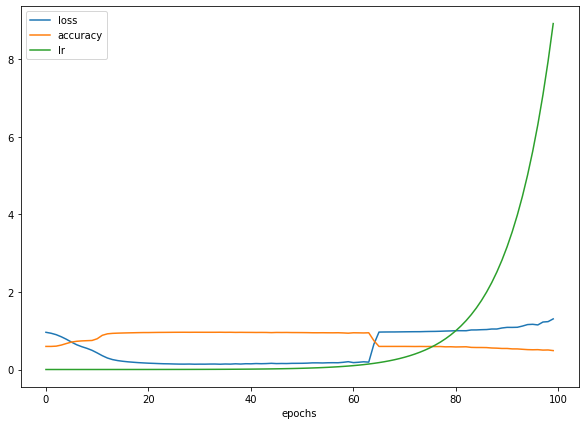

In [16]:
# Checkout the history
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs")

Text(0.5, 1.0, 'Learning rate vs. loss')

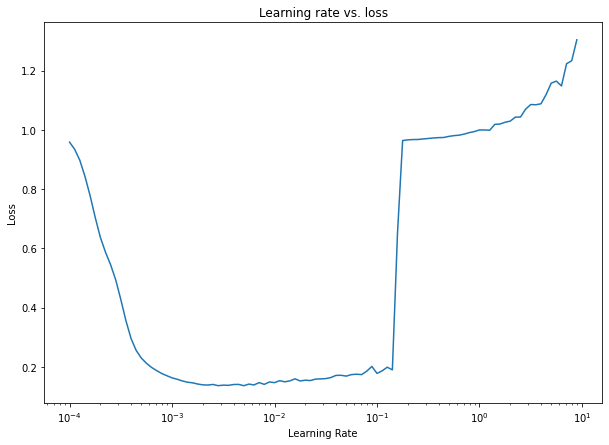

In [17]:
import matplotlib.pyplot as plt
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss")

In [57]:
# Create the model using the Sequential API
model = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax) # ouput layer, softmax activation
])

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
                metrics=['accuracy'])
# set class weight
class_weight = {0: 1/0.6,
                1: 1/0.2,
                2: 1/0.2}
# Fit the model
model.fit(X_train, Y_train, epochs=20, verbose=1, class_weight=class_weight)

# Evaluate our model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

Epoch 1/20
1500/1500 [==============================] - 4s 2ms/step - loss: 2.5529 - accuracy: 0.4611
Epoch 2/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7205 - accuracy: 0.9191
Epoch 3/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5369 - accuracy: 0.9376
Epoch 4/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5039 - accuracy: 0.9428
Epoch 5/20
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4504 - accuracy: 0.9483
Epoch 6/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4368 - accuracy: 0.9493
Epoch 7/20
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4423 - accuracy: 0.9515
Epoch 8/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4377 - accuracy: 0.9502
Epoch 9/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4302 - accuracy: 0.9532
Epoch 10/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.417

In [58]:
from sklearn.metrics import confusion_matrix

Y_probs = model.predict(X_test)
Y_preds = tf.argmax(Y_probs, axis=1)

# Create a confusion matrix
confusion_matrix(Y_test, Y_preds)

array([[6732,  394,   67],
       [ 145, 2128,    0],
       [   2,    0, 2532]], dtype=int64)

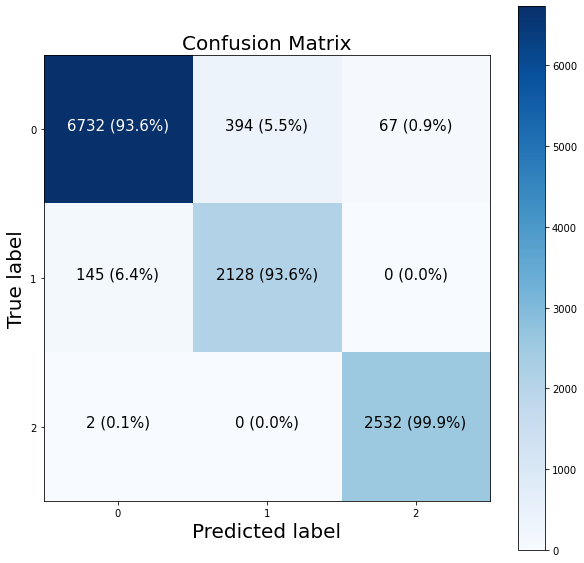

In [59]:
import itertools

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(Y_test, Y_preds)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# figure 
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)

In [60]:
df = pd.read_csv('./test.csv')
df.head()

,id,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
0,0,1.237662e+18,256.214932,20.212813,23.66373,21.13595,19.29212,18.60851,18.19255,3926,5,219,1.604448e+18,0.396574,1425,52913,146
1,1,1.237665e+18,117.219826,15.440152,21.01065,18.27865,17.23545,16.82708,16.60650,4517,2,29,5.061046e+18,0.000013,4495,55566,459
2,2,1.237662e+18,223.137071,44.963879,24.74111,24.13408,21.87315,20.56357,19.75502,3964,2,78,9.561407e+18,0.629711,8492,58171,965
3,3,1.237652e+18,199.078536,2.235425,18.30086,17.48638,16.93336,16.56529,16.36035,1458,3,496,5.923083e+17,0.072470,526,52312,309
4,4,1.237655e+18,138.588799,49.098189,24.40693,21.92935,21.79542,21.74201,21.52181,2243,2,148,6.454984e+18,-0.000024,5733,56575,726


In [61]:
df = df.set_index('id')
df.info()
# data for prediction
X_test = df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27998 entries, 0 to 27997
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       27998 non-null  float64
 1   alpha        27998 non-null  float64
 2   delta        27998 non-null  float64
 3   u            27998 non-null  float64
 4   g            27998 non-null  float64
 5   r            27998 non-null  float64
 6   i            27998 non-null  float64
 7   z            27998 non-null  float64
 8   run_ID       27998 non-null  int64  
 9   cam_col      27998 non-null  int64  
 10  field_ID     27998 non-null  int64  
 11  spec_obj_ID  27998 non-null  float64
 12  redshift     27998 non-null  float64
 13  plate        27998 non-null  int64  
 14  MJD          27998 non-null  int64  
 15  fiber_ID     27998 non-null  int64  
dtypes: float64(10), int64(6)
memory usage: 3.6 MB


In [62]:
# predict for the test.csv data
Y_prob = model.predict(X_test)
Y_pred = tf.argmax(Y_probs, axis=1)

dataframe = pd.DataFrame({'label':Y_pred})
dataframe.to_csv ("sample_submission.csv", mode="w", index = True, index_label='id', header=True)